In [1]:
# -*- coding: utf-8 -*-
"""
Created on Mon Aug 15 14:49:58 2022

@author: Sidi Wu and Cédric Beaulac

Functional autoencoder implementation
"""

# Import modules
import sys
import torch
import torch.nn.init as init
import torch.nn.functional as F
import torch.nn as nn
from torch import optim
from torch.autograd import Variable
from torchvision import datasets, transforms
from torchvision.utils import save_image
import pandas as pd
import numpy as np
from numpy import *
import seaborn as sns
import matplotlib
#matplotlib.use('TkAgg')
from matplotlib import pyplot as plt
# import skfda as fda
# from skfda import representation as representation
# from skfda.exploratory.visualization import FPCAPlot
# # from skfda.exploratory.visualization import FPCAPlot
# # from skfda.preprocessing.dim_reduction import FPCA
# # from skfda.representation.basis import BSpline, Fourier, Monomial
import scipy
from scipy.interpolate import BSpline
import os
import ignite
import sklearn
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.cluster import KMeans
import random
from random import seed
from scipy import stats
import statistics
from statistics import stdev
import skfda
from skfda import FDataGrid as fd
from sklearn.utils import shuffle


In [2]:

# os.chdir('C:/classifier')
os.chdir('C:/Users/Utilisateur/Documents/Master_SSD/STAGE_RECHERCHE/FDA_python')
if not os.getcwd() in sys.path:
    sys.path.append(os.getcwd())
import DataGenerator
from DataGenerator import *
import DataGenerator_NN
from DataGenerator_NN import *
import Functions
from Functions import *


In [3]:
##Importation des données sous forme FDA

ElNino_OISST_region_1and2=skfda.datasets.fetch_cran("ElNino_OISST_region_1and2","rainbow")
ElNino_OISST_region_3=skfda.datasets.fetch_cran("ElNino_OISST_region_3","rainbow")
ElNino_OISST_region_4=skfda.datasets.fetch_cran("ElNino_OISST_region_4","rainbow")
ElNino_OISST_region_3and4=skfda.datasets.fetch_cran("ElNino_OISST_region_3and4","rainbow")


c:\Users\Utilisateur\anaconda3\lib\site-packages\rdata\conversion\_conversion.py:843: UserWarning: Missing constructor for R class "sfts". The constructor for class "fts" will be used instead.
  warnings.warn(
c:\Users\Utilisateur\anaconda3\lib\site-packages\rdata\conversion\_conversion.py:843: UserWarning: Missing constructor for R class "fts". The constructor for class "fds" will be used instead.
  warnings.warn(
c:\Users\Utilisateur\anaconda3\lib\site-packages\rdata\conversion\_conversion.py:843: UserWarning: Missing constructor for R class "fds". The underlying R object is returned instead.
  warnings.warn(
c:\Users\Utilisateur\anaconda3\lib\site-packages\rdata\conversion\_conversion.py:843: UserWarning: Missing constructor for R class "sfts". The constructor for class "fts" will be used instead.
  warnings.warn(
c:\Users\Utilisateur\anaconda3\lib\site-packages\rdata\conversion\_conversion.py:843: UserWarning: Missing constructor for R class "fts". The constructor for class "fds" w

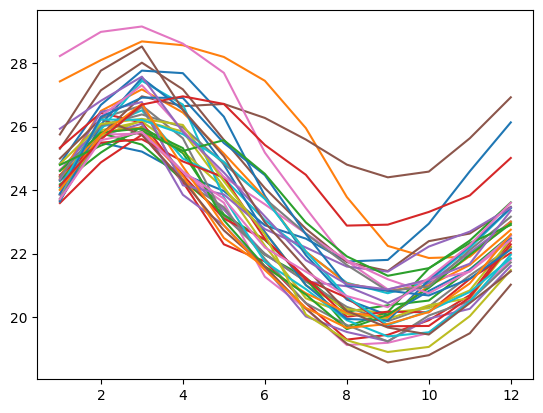

In [4]:
ElNino_OISST_region_1and2_y=ElNino_OISST_region_1and2['ElNino_OISST_region_1and2']['y'].to_numpy()
ElNino_OISST_region_1and2_x=ElNino_OISST_region_1and2['ElNino_OISST_region_1and2']['x']
plt.plot(ElNino_OISST_region_1and2_x,ElNino_OISST_region_1and2_y)
plt.show(
)

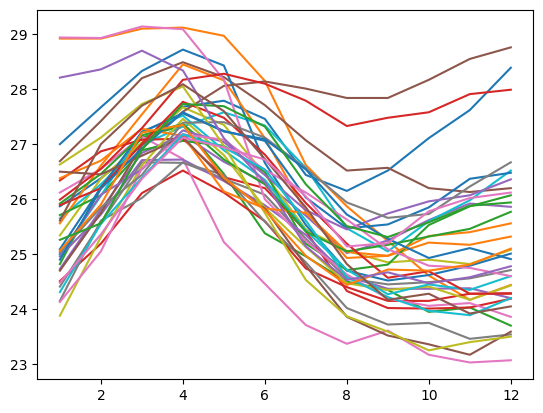

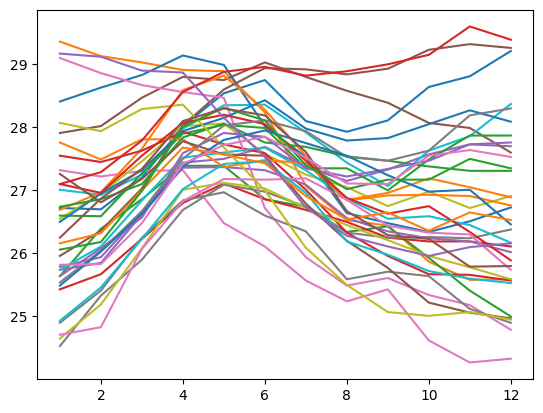

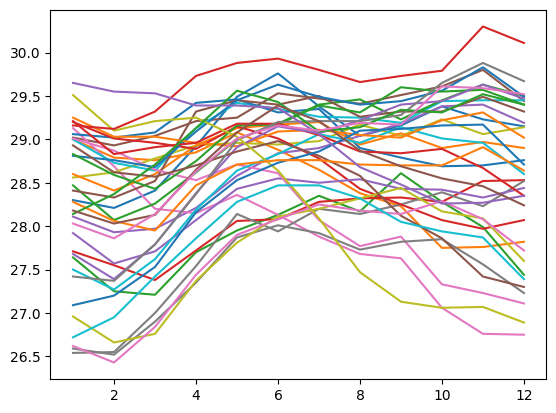

In [5]:
ElNino_OISST_region_3_y=ElNino_OISST_region_3['ElNino_OISST_region_3']['y'].to_numpy()
ElNino_OISST_region_3_x=ElNino_OISST_region_3['ElNino_OISST_region_3']['x']
plt.plot(ElNino_OISST_region_3_x,ElNino_OISST_region_3_y)
plt.show(

)
ElNino_OISST_region_3and4_y=ElNino_OISST_region_3and4['ElNino_OISST_region_3and4']['y'].to_numpy()
ElNino_OISST_region_3and4_x=ElNino_OISST_region_3and4['ElNino_OISST_region_3and4']['x']
plt.plot(ElNino_OISST_region_3and4_x,ElNino_OISST_region_3and4_y)
plt.show(
)


ElNino_OISST_region_4_y=ElNino_OISST_region_4['ElNino_OISST_region_4']['y'].to_numpy()
ElNino_OISST_region_4_x=ElNino_OISST_region_4['ElNino_OISST_region_4']['x']
plt.plot(ElNino_OISST_region_4_x,ElNino_OISST_region_4_y)
plt.show(
)
grid_points=ElNino_OISST_region_1and2_x


In [228]:

#################################################
# classifier: one hidden layer
# Encoder: a added layer for fd representation
# Decoder:
#################################################

#####################################
# Define the vanilla classifier architecture
# Create classifier Class
#####################################
class Functionnal_Classifier(nn.Module):
    def __init__(self, weight_std=None):
        super(Functionnal_Classifier, self).__init__()
        self.fc1 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(6, 120,bias=False))
        self.fc11 = nn.Linear(120, 64, bias=False)
        # self.fc12 = nn.Linear(25, 10, bias=False)
        self.fc2 = nn.Linear(64, 32, bias=False)
        # self.fc1 = nn.Linear(n_basis, n_rep, bias=False)
        self.fc3 = nn.Linear(32, 64, bias=False)
        # self.fc3 = nn.Linear(n_rep, n_basis, bias=False)
        self.fc4 = nn.Linear(64, 4, bias=False)
        self.activation = nn.Tanh()

        # initialize the weights to a specified, constant value
        if (weight_std is not None):
            for m in self.modules():
                if isinstance(m, nn.Linear):
                    nn.init.normal_(m.weight, mean=0.0, std=weight_std)
                    #nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x=x.float()
        feature = self.Project(x,)
        # rep = self.activation(self.fc1(feature))
        feature=feature.float().cuda()
        t1 = self.activation(self.fc1(feature))
        t1 = self.activation(self.fc11(t1))
        # t1 = self.activation(self.fc12(t1))
        rep = self.fc2(t1)
        t2 = self.activation(self.fc2(t1))
        t3=self.fc3(t2)
        coefs = self.fc4(t3)
        prob=self.Revert(x,coefs=coefs)
        # coef = self.fc3(rep)
        
        return prob.unsqueeze_(dim=2).unsqueeze_(dim=3)
    def Project(self, x):
        # basis_fc: n_time X nbasis
        # x: n_subject X n_time
        basis_fc=torch.tensor(fd(x[:,0,:].cpu(),grid_points=grid_points).to_basis(basis).coefficients).float().cuda()
        w = x.size(2)-1
        W = torch.tensor([1/(2*w)]+[1/w]*(w-1)+[1/(2*w)])
        f = torch.matmul(torch.t(torch.mul(x.squeeze(1), W.cuda())),basis_fc)
        return f
    
    
    def Revert(self, x,coefs):
        g = torch.matmul(x.squeeze(1),coefs)
        return g

In [7]:

def pred(model, data):
    model.eval()
    # input = data.type(torch.LongTensor)
    input = data.cuda()
    output, rep, feature, coef = model(input.float(), basis_fc)
    loss = loss_function(output, input.float())
    score_loss = loss_function(feature, coef)
    return output, rep, loss, score_loss

#####################################
# Load Data sets
#####################################
# Import dataset
# Dataset: tecator
# x_raw = pd.read_csv('Datasets/tecator/tecator.csv')
# tpts_raw = pd.read_csv('Datasets/tecator/tecator_tpts.csv')
# Dataset: pinch
# x_raw = pd.read_csv('Datasets/pinch/pinch.csv')
# tpts_raw = pd.read_csv('Datasets/pinch/pinch_tpts.csv')


In [8]:
x0=torch.tensor(ElNino_OISST_region_1and2_y).float().cuda()
x1=torch.tensor(ElNino_OISST_region_3_y).float().cuda()
x2=torch.tensor(ElNino_OISST_region_4_y).float().cuda()
x3=torch.tensor(ElNino_OISST_region_3and4_y).float().cuda()
x0=torch.t(x0)
x1=torch.t(x1)
x2=torch.t(x2)
x3=torch.t(x3)

# train_index=np.random.permutation(torch.tensor(np.arange(30)))
# labels = torch.tensor([0] * x0.shape[0] + [1] * x1.shape[0] + [2] * x2.shape[0] + [3] * x3.shape[0])
# x0_train,y0_train=x0[train_index,:],labels[train_index]
# x1_train,y1_train=x1[train_index,:],labels[train_index]
# x2_train,y2_train=x2[train_index,:],labels[train_index]
# x3_train,y3_train=x3[train_index,:],labels[train_index]
# X=torch.concatenate([x0_train,x1_train,x2_train,x3_train],axis=0)
# X_test=torch.concatenate([x0[~train_index],x1[~train_index],x2[~train_index],x3[~train_index]],axis=0)
# Y_test=torch.tensor(labels[~train_index_long])
# Y_test

In [22]:

labels = torch.tensor([0] * x0.shape[0] + [1] * x1.shape[0] + [2] * x2.shape[0] + [3] * x3.shape[0])
X=torch.concatenate([x0,x1,x2,x3])
x_train,x_test,y_train,y_test=sklearn.model_selection.train_test_split(X,labels,shuffle=True)
x_train=x_train.reshape(111,1,12).cuda()
y_train=y_train.unsqueeze(1).cuda()
x_test=x_test.reshape(37,1,12).cuda()
y_test=y_test.unsqueeze(1).cuda()




x_train de la région 1 et 2


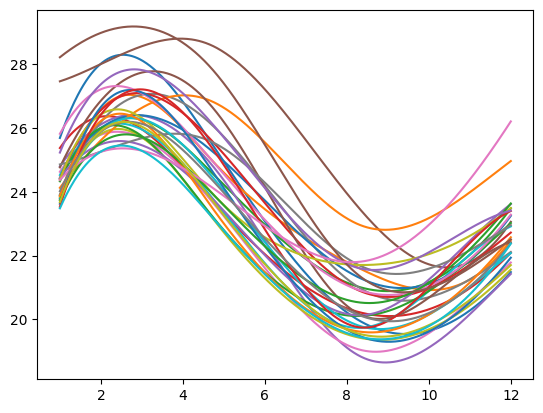

basis d.ordre 4 à 4 noeuds


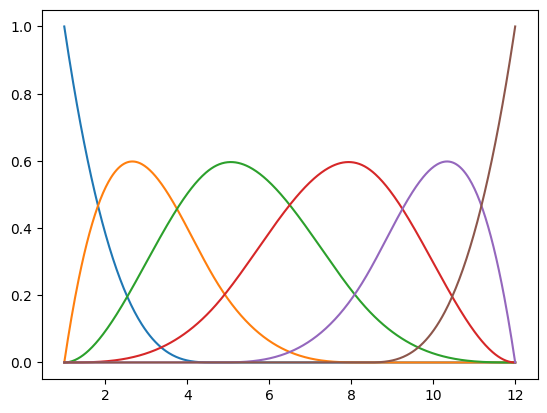

In [182]:

X_grid=fd(x_train[y_train==0].cpu(),grid_points=grid_points)
basis=skfda.representation.basis.BSplineBasis(knots=np.linspace(1,12,4),order=4)
n_basis=basis.n_basis
basis_X=X_grid.to_basis(basis=basis)
basis_fc=torch.tensor(basis_X.coefficients).float().cuda()
basis_X.plot()
print('x_train de la région 1 et 2')
plt.show() 
##Une fois les coefficients récupérés, on en fait une fonction de x puis 
##x vaudra une discrétisation du temps.
##On va zoomer la courbe pour faire de la convolution.
basis_fc.shape
basis.plot()
print('basis d.ordre 4 à 4 noeuds')
plt.show()

In [183]:
x =torch.tensor(ElNino_OISST_region_1and2_y).cuda()
w = X.size(1)-1
W = torch.tensor([1/(2*w)]+[1/w]*(w-1)+[1/(2*w)])
W


tensor([0.0455, 0.0909, 0.0909, 0.0909, 0.0909, 0.0909, 0.0909, 0.0909, 0.0909,
        0.0909, 0.0909, 0.0455])

In [136]:
grid_points=ElNino_OISST_region_1and2_x
[ElNino_OISST_region_1and2_y.shape,

print("grid_points=",grid_points)]
64*37

grid_points= [ 1  2  3  4  5  6  7  8  9 10 11 12]


2368

In [229]:
classifier=Functionnal_Classifier(weight_std=0.3)
classifier=classifier.cuda()
classifier.parameters()


<generator object Module.parameters at 0x0000021570E34510>

In [230]:
print([classifier.Project(x_train).shape,
basis_fc.shape])
project_out=classifier.Project(x_train)
project_out.shape

[torch.Size([12, 6]), torch.Size([30, 6])]


torch.Size([12, 6])

In [231]:
[classifier.fc1(project_out).shape,
classifier.fc11(classifier.fc1(project_out)).shape,
classifier.fc2(classifier.fc11(classifier.fc1(project_out))).shape]

[torch.Size([12, 120]), torch.Size([12, 64]), torch.Size([12, 32])]

In [232]:
classifier(x_train).shape
len(x_train)

111

In [233]:
lr=0.001
betas=[0.5,0.999]
batch_size=3

loss_function=nn.CrossEntropyLoss()
optimizer=optim.Adam(classifier.parameters(),lr=lr,betas=betas)


#print("Loader entier=",train_loader.dataset.shape)
#for i,b in enumerate(train_loader):
#    print ("Itération du",i,"ème batch=",b.shape)

In [234]:
i=1
functions_train=x_train[batch_size*i:batch_size*(1+i),:,:]
labels_train=y_train[batch_size*i:batch_size*(1+i)]
optimizer.zero_grad()
output=classifier(functions_train)
print(output.shape,labels_train.shape)
# loss=loss_function(input=output,target=labels_train.unsqueeze(1).long())
        

torch.Size([3, 4, 1, 1]) torch.Size([3, 1])


In [259]:

from tqdm import tqdm
def train(n_epochs):
    train_loss=torch.tensor(0).cuda().long()
    for i in range(int(len(x_train)/batch_size)):
        functions_train=x_train[batch_size*i:batch_size*(1+i),:,:]
        labels_train=y_train[batch_size*i:batch_size*(1+i)]
        optimizer.zero_grad()
        output=classifier(functions_train)
        loss=loss_function(input=output,target=labels_train.unsqueeze(1).long())
        
        loss.backward()
        optimizer.step()
        train_loss+=loss.long()
    return train_loss,loss 

        


        


In [260]:

train(1)




(tensor(2803, device='cuda:0'),
 tensor(20.3662, device='cuda:0', grad_fn=<NllLoss2DBackward0>))

In [258]:
torch.sum(torch.argmax(classifier(x_test),dim=1)==y_test)/37

tensor(0.2432, device='cuda:0')

In [256]:
y_test.shape
x_test.shape

torch.Size([37, 1, 12])

In [237]:
loss_function(classifier(x_test),y_test.unsqueeze_(dim=1))

tensor(107.5467, device='cuda:0', grad_fn=<NllLoss2DBackward0>)

In [240]:
torch.mean(torch.square(classifier(x_test)-y_test.squeeze(1)))

tensor(63397.2617, device='cuda:0', grad_fn=<MeanBackward0>)

In [261]:
import gc
import torch
torch.cuda.empty_cache()
gc.collect()

5468